In [1]:
#@title Librerias
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from scipy.interpolate import CubicSpline
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import interp1d
import sympy as sp
sp.init_printing()
import pandas as pd
import urllib.request

# Actividad 05: Interpolación

---
### Profesor: Juan Marcos Marín
### Nombre: ______
*Métodos computacionales 2025-I*

---

# 1
Supongamos que queremos interpolar la función  $f(x)=\sin(x)$  usando los puntos  $x_0=0$ ,  $x_1=\pi/2$ , y  $x_2=\pi$.

Encuentre el polinomio de interpolación de Lagrange y el error asociado al misma. Recuerde que el error de interpolación de Lagrange puede expresarse explícitamente como:

\begin{equation}
f(x) - P(x) = \epsilon = \frac{1}{(n+1)!} f^{(n+1)}(\xi)(x - x_0)(x - x_1) ... (x - x_n)
\end{equation}

Donde:
- $f^{(n+1)}(\xi)$ es la derivada de orden $n$ de la función $f(x)$ evaluada en algún punto $\xi$ en el intervalo de interpolación.

- Repita el numeral anterior, pero para los polinomios de interpolación de Hermite, conociendo que:


$$
f(x) - P(x) = \epsilon = \frac{f^{(2n+2)}(\xi)}{(2n+2)!} \prod_{i=0}^{n} (x - x_i)^2
$$

*Nota: recuerde que los indices en python inician en 0, luego si tenemos $n+1$ datos el polinomio es de orden $n$*

In [2]:
x_vals = [0, np.pi/2, np.pi]
f = lambda x: np.sin(x)
df = np.cos(x_vals)
y_vals = f(x_vals)
Pol_lagrange = lagrange(x_vals, y_vals)
Pol_lagrange
Pol_Hermite = CubicHermiteSpline(x_vals, y_vals, df)
Pol_Hermite

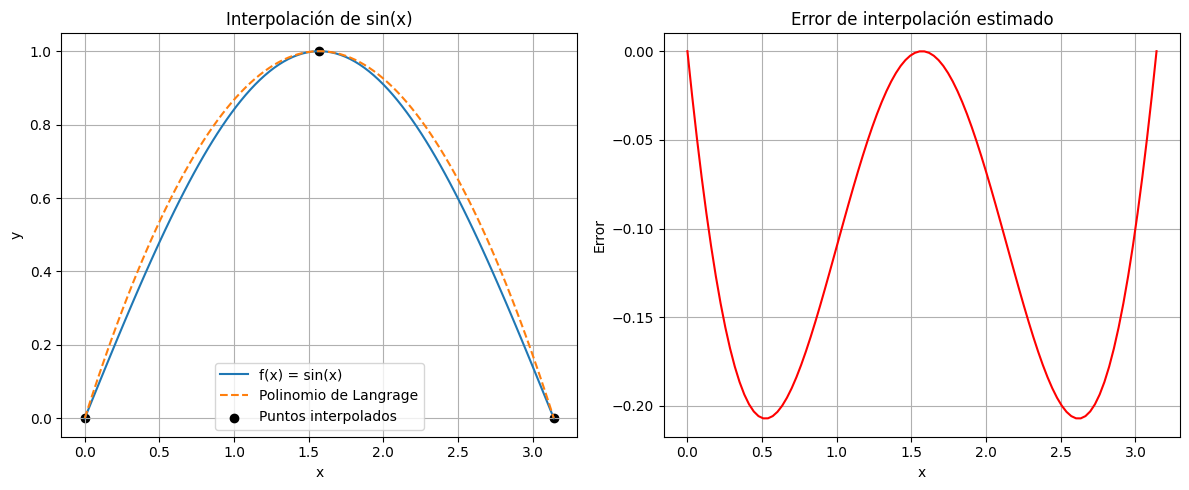

Polinomio de Lagrange:
         2
-0.4053 x + 1.273 x


In [3]:
#Error de interpolación de Lagrange
x = sp.symbols('x')
f_sym = sp.sin(x)
f3_sym = sp.diff(f_sym, x, 3)
f3 = sp.lambdify(x, f3_sym , 'numpy')
x_0, x_1, x_2 = x_vals

error_langrage = lambda x: (f3(x)/6)*(x - x_0)*(x - x_1)*(x - x_2)
x_interp = np.linspace(min(x_vals), max(x_vals), 100)
f_real = np.sin(x_interp)
f_interp = Pol_lagrange(x_interp)
error_val = error_langrage(x_interp)

plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_interp, f_real, label='f(x) = sin(x)')
plt.plot(x_interp, f_interp, '--', label = 'Polinomio de Langrage')
plt.scatter(x_vals, y_vals, color = 'black', label = 'Puntos interpolados')
plt.title('Interpolación de sin(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_interp, error_val, color = 'red', label = 'Error teórico')
plt.title('Error de interpolación estimado')
plt.xlabel('x')
plt.ylabel('Error')
plt.grid()
plt.tight_layout()

plt.show()
print('Polinomio de Lagrange:')
print(Pol_lagrange)

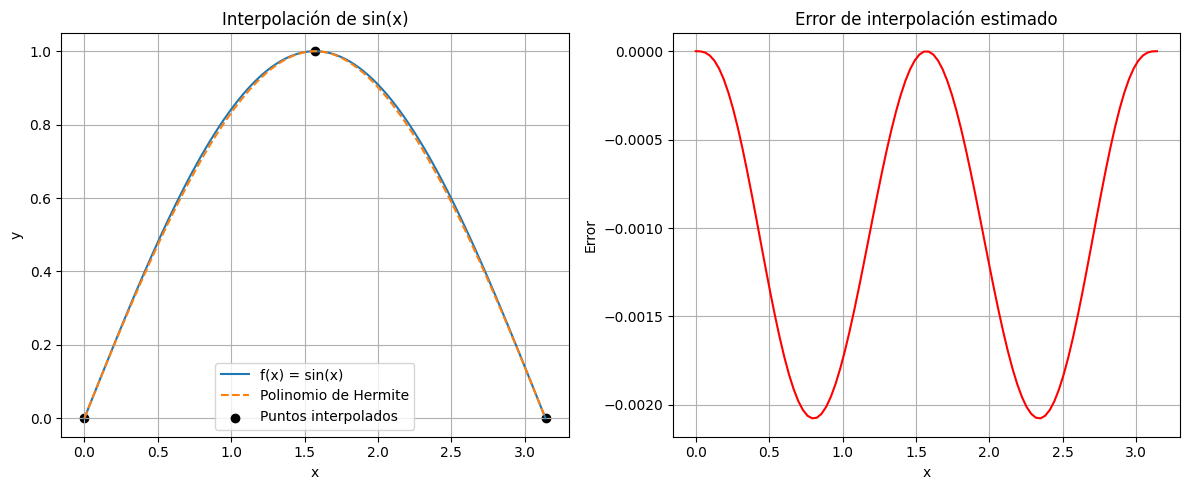

In [4]:
#Error de interpolación de Hermite
f6_sym = sp.diff(f_sym, x, 6)
f6 = sp.lambdify(x, f6_sym, 'numpy')
error_Hermite = lambda x: (f6(x)/sp.factorial(6))*((x - x_0)**2)*((x - x_1)**2)*((x - x_2)**2)

f_interp1 = Pol_Hermite(x_interp)
error_val1 = error_Hermite(x_interp)

plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_interp, f_real, label='f(x) = sin(x)')
plt.plot(x_interp, f_interp1, '--', label = 'Polinomio de Hermite')
plt.scatter(x_vals, y_vals, color = 'black', label = 'Puntos interpolados')
plt.title('Interpolación de sin(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_interp, error_val1, color = 'red', label = 'Error teórico')
plt.title('Error de interpolación estimado')
plt.xlabel('x')
plt.ylabel('Error')
plt.grid()
plt.tight_layout()

plt.show()

# 2

En física nuclear se calcula la sección eficaz de dispersión (scattering cross section) a partir de experimentos de colisiones, se sabe a partir de la teoría que la sección eficaz se describe por la formula de Breit-Wigner,

$$\sigma(E)=\frac{\sigma_0}{(E-E_r)^2+\frac{\Gamma^2}{4}}$$

donde $E$ es la energía y $E_r,\sigma_0, \Gamma$ son parámetros a ajustar; el valor predicho es $(E_r,\Gamma) = (78, 55)$ MeV; donde $\sigma_0$ se puede calcular ahora a partir de la fórmula simplemente remplazando cualquier par de puntos de la tabla.

A partir de los valores de energía,


```
Energia  = np.array([0   , 25  , 50  , 75  , 100 , 125 , 150 , 175 , 200])
sigma_exp= np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])

```

* Calcule los polinomios de Lagrange, Newton y Hermite.

* Haga un gráfico de los polinomios junto con la función original.

* Finalmente, a partir de la diferencia $|f(x) - P_n(x)|$ calcule el máximo   error asociado a cada uno de ellos. ¿Cuál será el mejor?

In [5]:
#Introducimos el Polinomio de Newton hecho por el profesor para usarlo

def diferencia_dividida(x, y, i, j):
    '''
    Calcula recursivamente la diferencia dividida f[x_i, x_{i+1}, ..., x_j]
    Entradas:
      x: array de puntos x
      y: array de puntos y
      i: indice del primer punto
      j: indice del ultimo punto
    Salidas:
      a: coeficiente diferencia dividida (i,j)
    '''
    if i == j:
        return y[i]
    else:
        num = diferencia_dividida(x, y, i + 1, j) - diferencia_dividida(x, y, i, j - 1)
        den = x[j] - x[i]
        return num / den

def coeficientes_a(x, y):
    '''
    Calcula los coeficientes a_i del polinomio de Newton.
    Entradas:
      x: array de puntos x
      y: array de puntos y
    Salidas:
      coeficientes: array de coeficientes a_i
    '''
    n = len(x)
    coeficientes = np.zeros_like(x, dtype=float)
    for i in range(n):
        coeficientes[i] = diferencia_dividida(x, y, 0, i)
    return coeficientes

def Polinomio_Newton(x, y):
  '''
  Calcula el polinomio de Newton a partir de los puntos (x, y)
  Entradas:
    x: array de puntos x
    y: array de puntos y
  Salidas:
    P: polinomio de Newton como una función de x
  '''
  coef = coeficientes_a(x, y)
  def P(x_val):
    resultado = coef[0]
    producto = 1
    for i in range(1, len(x)):
      producto *= (x_val - x[i - 1])
      resultado += coef[i] * producto
    return resultado
  return P

In [6]:
Energia  = np.array([0   , 25  , 50  , 75  , 100 , 125 , 150 , 175 , 200])
sigma_exp= np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])
E_r, Gamma = 78, 55
#Utilizaremos el par E = 0 y sigma_exp = 10.6
sigma_0 = sigma_exp[0] * (((Energia[0] - E_r)**2) + ((Gamma**2)/4))
print(f'Sigma_0 = {sigma_0}')

Breit_Wigner = lambda E: sigma_0/(((E - E_r)**2) + (Gamma**2)/4)
#Sacamos la derivada para Hermite
E_sym = sp.symbols('E')
f_sym = sigma_0/(((E_sym - E_r)**2) + (Gamma**2)/4)
f_prima_sym = sp.diff(f_sym, E_sym)
f_prima = sp.lambdify(E_sym, f_prima_sym , 'numpy')
y_prima = f_prima(Energia)

#Hallar cada polinomio
y_vals2 = Breit_Wigner(Energia)
E = np.linspace(min(Energia), max(Energia), 100)
f_real2 = Breit_Wigner(E)
Pol_lagrange2 = lagrange(Energia, y_vals2)
f_interp2_L = Pol_lagrange2(E)
Pol_Hermite2 = CubicHermiteSpline(Energia, y_vals2, y_prima)
f_interp2_H = Pol_Hermite2(E)
Pol_Newton2 = Polinomio_Newton(Energia, sigma_exp)
f_interp2_N = Pol_Newton2(E)

#Máximo error
def Error_max(Pol, f):
  return max(abs(f - Pol))

max_error_langrage = Error_max(Pol_lagrange2, y_vals2)
max_error_langrage

Sigma_0 = 72506.65


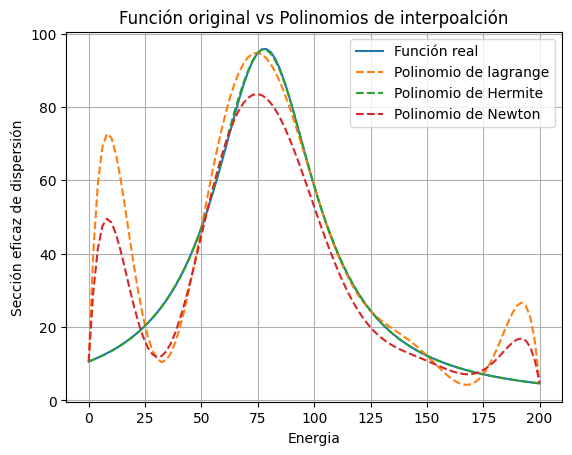

In [7]:
#Gráfica de cada polinomio contra la función original
plt.plot(E, f_real2, label = 'Función real')
plt.plot(E, f_interp2_L, '--', label = 'Polinomio de lagrange')
plt.plot(E, f_interp2_H, '--', label = 'Polinomio de Hermite')
plt.plot(E, f_interp2_N, '--', label = 'Polinomio de Newton')
plt.title('Función original vs Polinomios de interpoalción')
plt.xlabel('Energia')
plt.ylabel('Sección eficaz de dispersión')
plt.grid()
plt.legend()

In [12]:
#Máximo error
def Error_max(Pol, f):
  return max(abs(f - Pol))

max_error_langrage = Error_max(f_interp2_L, f_real2)
max_error_hermite = Error_max(f_interp2_H, f_real2)
max_error_newton = Error_max(f_interp2_N, f_real2)
print(f'El máximo error en el polinomio de Langrage es: {max_error_langrage}')
print(f'El máximo error en el polinomio de Hermite es: {max_error_hermite}')
print(f'El máximo error en el polinomio de Newton es: {max_error_newton}')

El máximo error en el polinomio de Langrage es: 59.87233137191324
El máximo error en el polinomio de Hermite es: 1.1750968583533563
El máximo error en el polinomio de Newton es: 36.67222898317847


# 3
Consideremos la función:
\begin{equation*}
     f(x) = \frac{1}{1+25x^2}
\end{equation*}
en el intervalo $[-1, 1]$, definamos un conjunto de puntos $n+1$  equiespaciados en $[-1,1]$.

* Representar gráficamente la función junto al polinomio de interpolación de Lagrange, $p_n(x)$, para $n=\{ 4, 8, 12, 16, 20 \}$.
* Comprobar gráficamente cómo el error aumenta con $n$. Emplee la libreria, simbolica de `sympy` y encuente el error en la interpolación. La cota del  error , viene dado por:
\begin{equation}
f(x) - P(x) = \epsilon = \frac{1}{(n+1)!} f^{(n+1)}(\xi)(x - x_0)(x - x_1) ... (x - x_n)
\end{equation},

emplee la libreria simbólica para realizar la estimación de dicha cuota, sólo para $n = 4$, en el punto $x=0.5$.

* Repita la parte inicial para el conjunto de $p_n(x)$ con $n=\{ 4, 8, 12, 16, 20 \}$, usando la interpolación de Hermite, ¿existe alguna diferencia?

* Usando los datos del numeral anterior ahora usando el método `CubicSpline` realiza la interpolación y concluya.

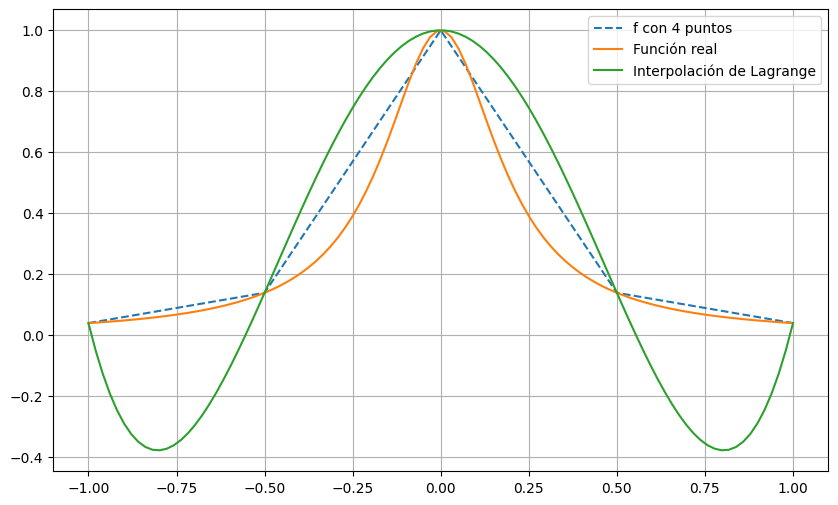

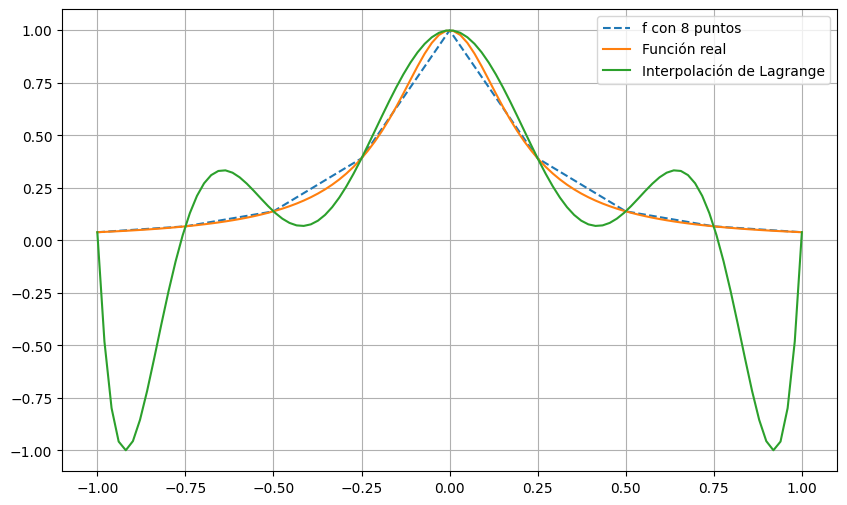

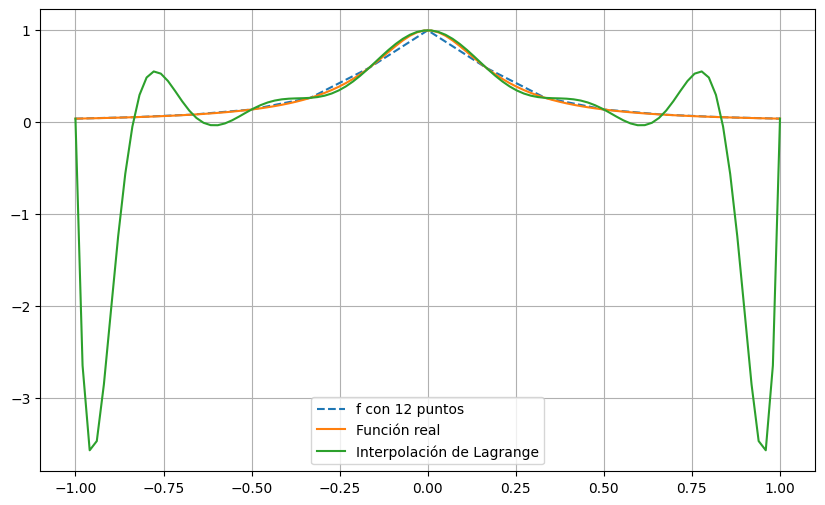

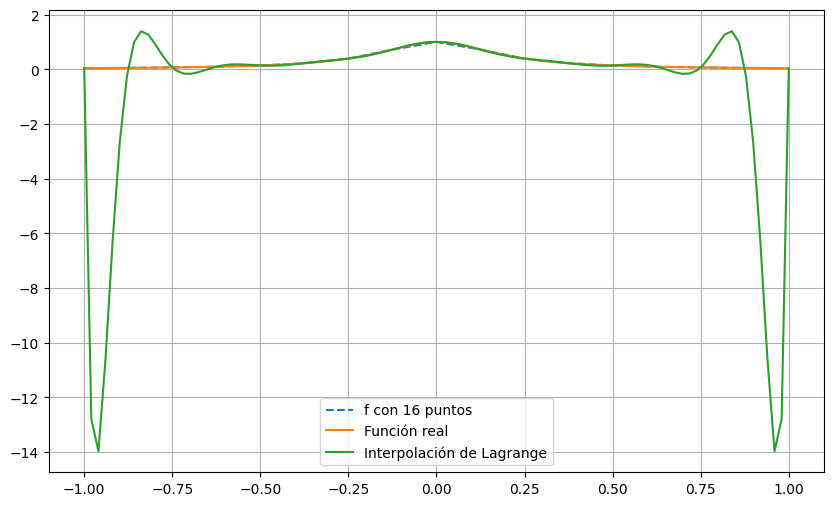

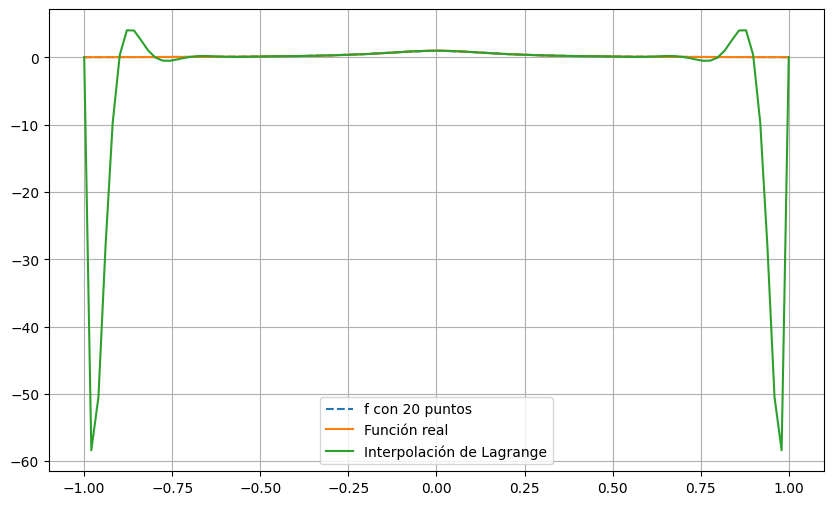

In [48]:
f = lambda x: 1/(1 + 25*x**2)
n = [4, 8, 12, 16, 20]
t = 100
x_vals = np.linspace(-1, 1, t)
y_vals = f(x_vals)
x_ = np.linspace(-1, 1, t)
y_ = f(x_)
for n_ in n:
  plt.figure(figsize=(10, 6))
  x = np.linspace(-1, 1, n_ + 1)
  y = f(x)
  Lagrange = lagrange(x, y)
  f_lagrange = Lagrange(x_vals)
  plt.plot(x, y, '--', label = f'f con {n_} puntos')
  plt.plot(x_, y_, label = 'Función real')
  plt.plot(x_vals, f_lagrange, label = 'Interpolación de Lagrange' )
  plt.legend()
  plt.grid()


In [61]:
#Ya se comprobó graficamente como al aumentar n, el error aumenta
#Error de interpolación de Lagrange
import math
x = sp.symbols('x')
f_sym = 1/(1 + 25*x**2)
f4_sym = sp.diff(f_sym, x, 4)
f4 = sp.lambdify(x, f4_sym , 'numpy')

x_eval = 0.5
x_vals_ = x_ = np.linspace(-1, 1, 4)
prod = 1

for x_i in x_vals_:
  prod *= (x_eval - x_i)

Cota = f4(x_eval)/math.factorial(4)*prod
print(f'Cota del error {Cota}')

Cota del error -0.4349260654941045


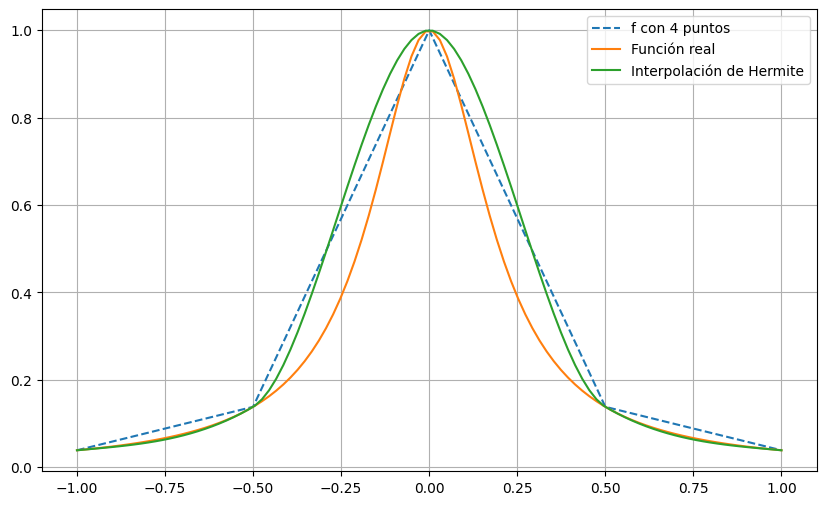

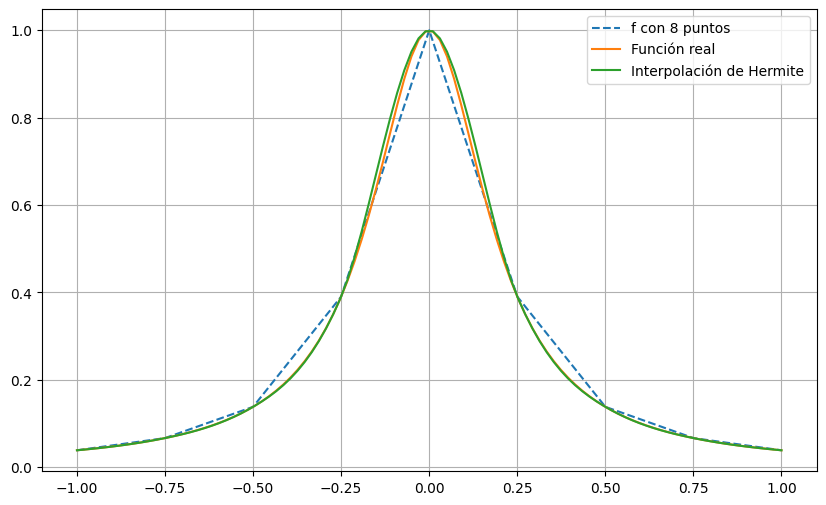

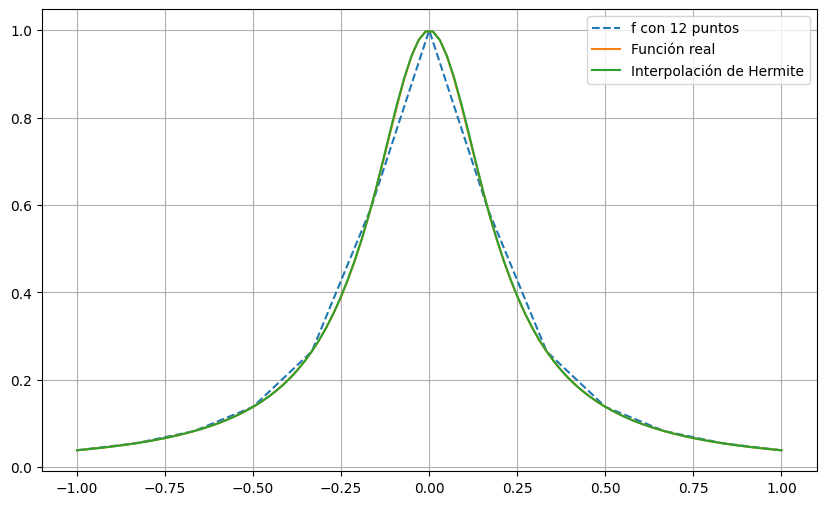

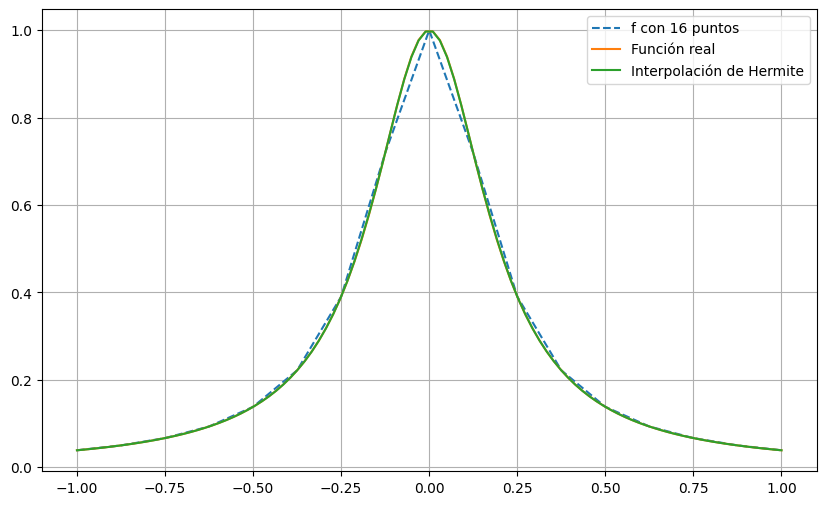

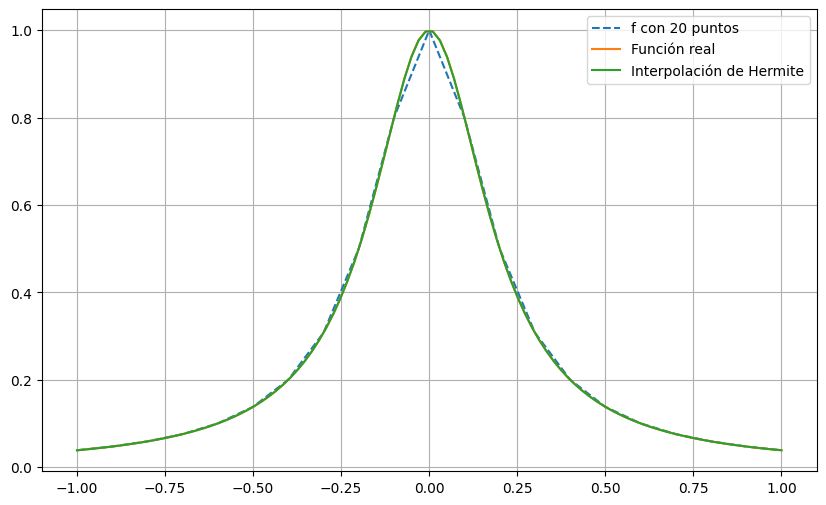

In [62]:
#Caso hermite
f = lambda x: 1/(1 + 25*x**2)
f_prima = sp.diff(f_sym, x)
f1 = sp.lambdify(x, f_prima, 'numpy')
n = [4, 8, 12, 16, 20]
t = 100
x_vals = np.linspace(-1, 1, t)
y_vals = f(x_vals)
x_ = np.linspace(-1, 1, t)
y_ = f(x_)
for n_ in n:
  plt.figure(figsize=(10, 6))
  x = np.linspace(-1, 1, n_ + 1)
  y = f(x)
  y_prima = f1(x)
  Hermite = CubicHermiteSpline(x, y, y_prima)
  f_Hermite = Hermite(x_vals)
  plt.plot(x, y, '--', label = f'f con {n_} puntos')
  plt.plot(x_, y_, label = 'Función real')
  plt.plot(x_vals, f_Hermite, label = 'Interpolación de Hermite' )
  plt.legend()
  plt.grid()

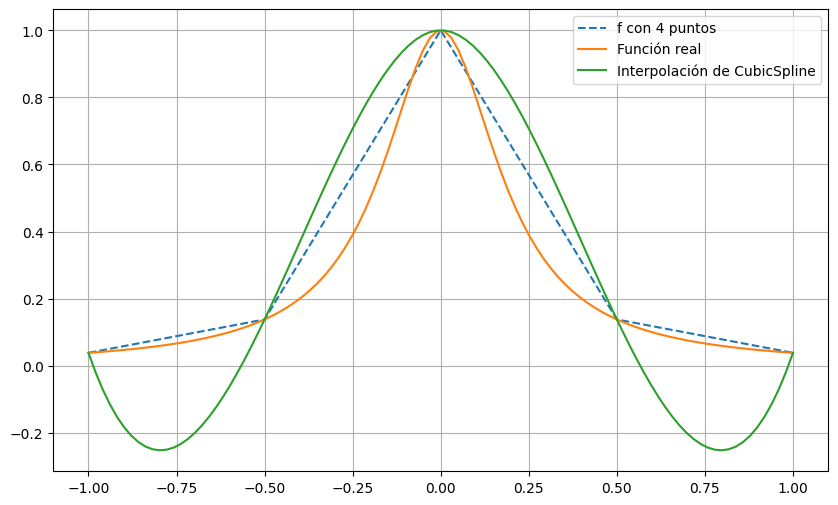

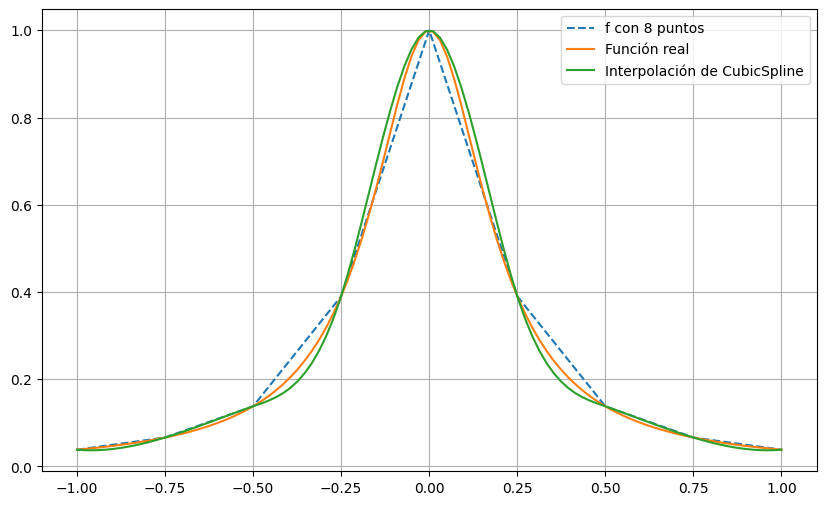

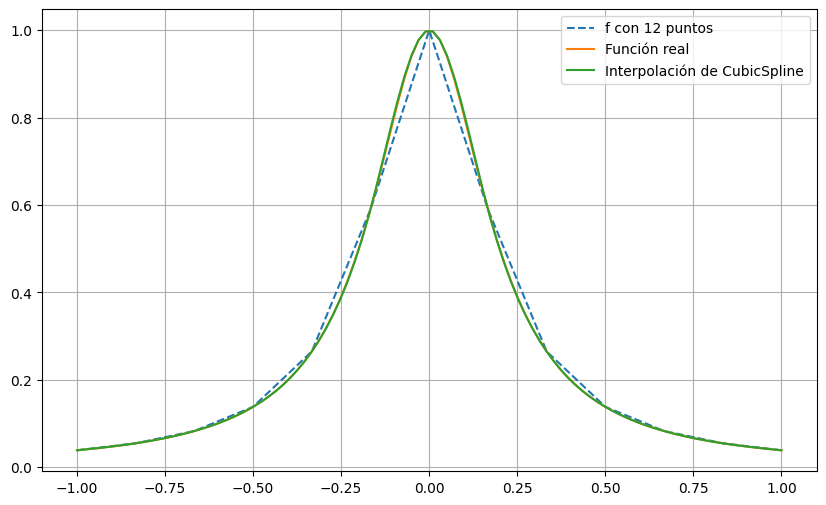

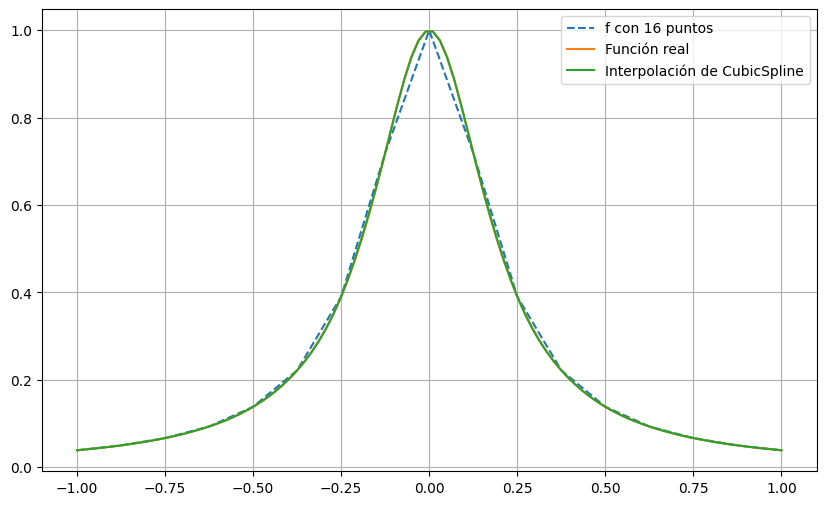

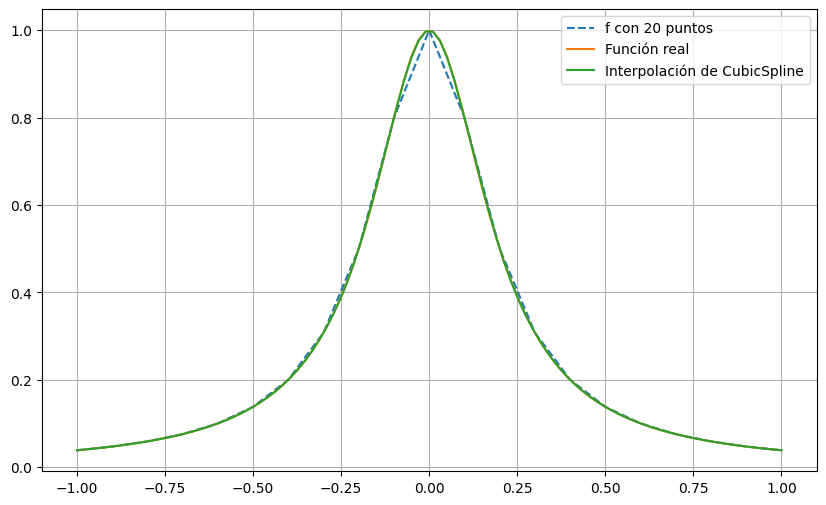

In [63]:
#Caso CubicSpline
f = lambda x: 1/(1 + 25*x**2)
n = [4, 8, 12, 16, 20]
t = 100
x_vals = np.linspace(-1, 1, t)
y_vals = f(x_vals)
x_ = np.linspace(-1, 1, t)
y_ = f(x_)
for n_ in n:
  plt.figure(figsize=(10, 6))
  x = np.linspace(-1, 1, n_ + 1)
  y = f(x)
  Cubic_Spline = CubicSpline(x, y)
  f_CubicSpline = Cubic_Spline(x_vals)
  plt.plot(x, y, '--', label = f'f con {n_} puntos')
  plt.plot(x_, y_, label = 'Función real')
  plt.plot(x_vals, f_CubicSpline, label = 'Interpolación de CubicSpline' )
  plt.legend()
  plt.grid()

Conclusiones de los 3 métodos:

 - De los 3, Hermite fué el que más rápido convergió.

 - Lagrange no se acercó al polinomio esperado.

 - Hermite y CubicSpline son dos métodos muy confiables si tenemos un buen número de puntos.

# 4

Consideremos la imagen ![paloma](https://github.com/hernansalinas/autogrades/blob/main/Laboratorios_Taller/img/paloma.png?raw=true).

Ref: Metodos numericos, Burden.


Con los datos dados en la tabla:

1. Representar gráficamente la imagen, usando las órdenes `imread` e `imshow` de python (estas órdenes están contenidas en el paquete `matplotlib`)

2. Definir una lista de puntos, $x_i$,$y_i$ del pato y realice una interpolación lineal entre los mismos.

3. Representar el polinomio de interpolación de Lagrange en estos puntos, para aproximar el dibujo.

4. Repetir el proceso de interpolación mediante *splines* cúbicos. Para ello, utilizar la función `CubicSpline` (contenida en `scipy.interpolate`),


5. Comparar los resultados. ¿Alguna de las interpolaciones presenta oscilaciones? ¿A qué se debe este fenómeno?

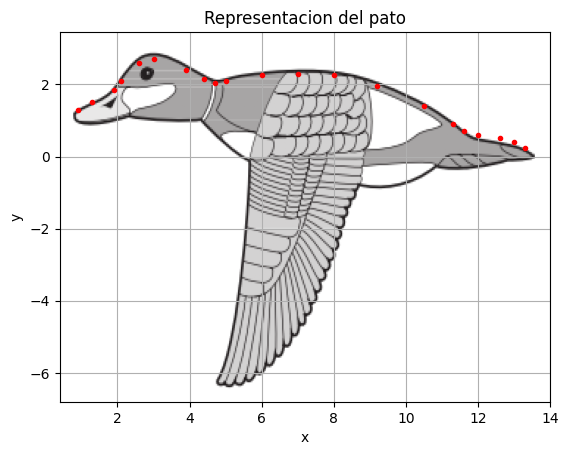

In [8]:
pato = 'https://3.bp.blogspot.com/-8_LTrCIxVSQ/VxU-5Gq2ffI/AAAAAAAAIto/LhCDEwHKTiAbLr7IhizQwGV13YTwgpbDwCLcB/s400/pato1.png' #URL
urllib.request.urlretrieve(pato, 'pato.jpg')# Decargar la imagen
imagen_pato = plt.imread('pato.jpg') # Variable con la imagen del pato

# Definimos los puntos del pato
xp = [0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 5.0, 6.0, 7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3]
yp = [1.3, 1.5, 1.85, 2.1, 2.6, 2.7, 2.4, 2.15, 2.05, 2.1, 2.25, 2.3, 2.25, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25]

# Representamos graficamente al pato y los puntos que definimos para su contorno superior
plt.figure()
plt.title('Representacion del pato')
plt.imshow(imagen_pato, extent = (0.4, 14, -6.8, 3.45)) # Ajustamos los pixeles para que coincidan con x e y
plt.plot(xp, yp, '.r')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

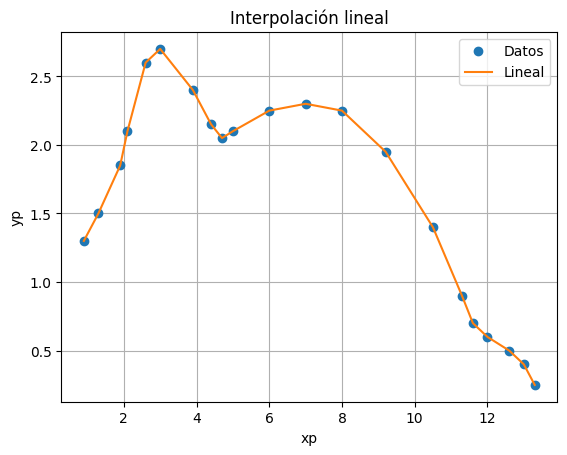

In [71]:
Lineal = interp1d(xp, yp, kind = 'linear')
plt.plot(xp, yp, 'o', label='Datos')
plt.plot(xp, Lineal(xp), label='Lineal')
plt.title('Interpolación lineal')
plt.xlabel('xp')
plt.ylabel('yp')
plt.legend()
plt.grid()

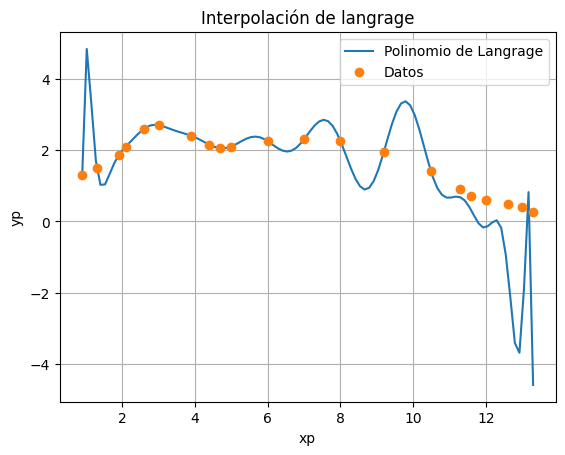

In [75]:
#Polinomio de Langrage
x_interp = np.linspace(min(xp), max(xp), 100)
Pol_Langrage_3 = lagrange(xp, yp)
Pol_interp = Pol_Langrage_3(x_interp)
plt.plot(x_interp, Pol_interp, label = 'Polinomio de Langrage')
plt.plot(xp, yp, 'o', label='Datos')
plt.title('Interpolación de langrage')
plt.xlabel('xp')
plt.ylabel('yp')
plt.legend()
plt.grid()

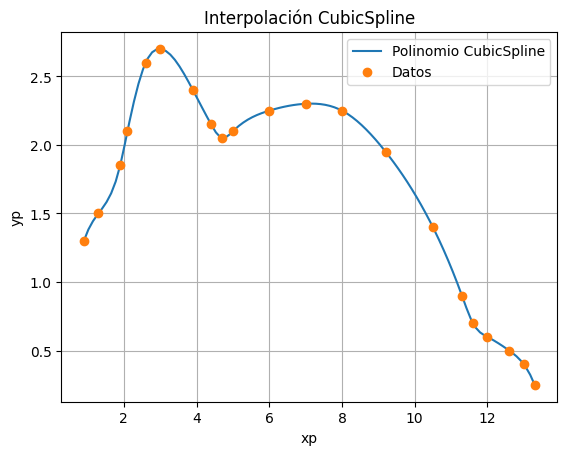

In [77]:
#Polinomio de CubicSpline
x_interp = np.linspace(min(xp), max(xp), 100)
Pol_CubicSpline_3 = CubicSpline(xp, yp)
Pol_interp_CS = Pol_CubicSpline_3(x_interp)
plt.plot(x_interp, Pol_interp_CS, label = 'Polinomio CubicSpline')
plt.plot(xp, yp, 'o', label='Datos')
plt.title('Interpolación CubicSpline')
plt.xlabel('xp')
plt.ylabel('yp')
plt.legend()
plt.grid()

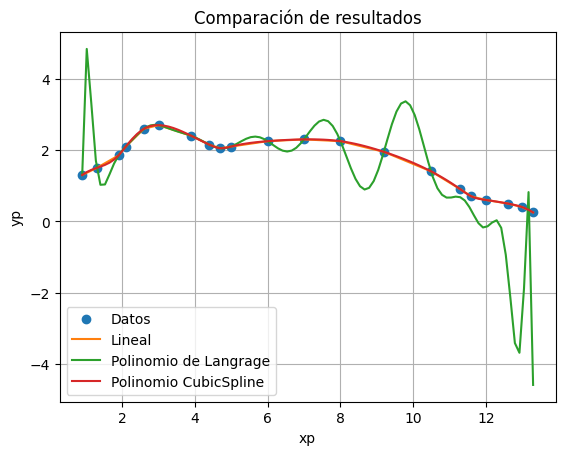

In [78]:
#Comparación de resultados
plt.plot(xp, yp, 'o', label='Datos')
plt.plot(xp, Lineal(xp), label='Lineal')
plt.plot(x_interp, Pol_interp, label = 'Polinomio de Langrage')
plt.plot(x_interp, Pol_interp_CS, label = 'Polinomio CubicSpline')
plt.title('Comparación de resultados')
plt.xlabel('xp')
plt.ylabel('yp')
plt.legend()
plt.grid()

Comparar los resultados. ¿Alguna de las interpolaciones presenta oscilaciones? ¿A qué se debe este fenómeno?

- Sí, oscila la de langrage ya que entre más puntos se le dé, más grande es el grado del polinomio de interpolación lo cual lo hace oscilar más.

- Por el contrario, lineal y CubicSpline usan métodos diferentes y tienen la característica de que funcionan mejor entre más puntos tengamos

# 5

Calcular el spline cúbico que interpola los puntos $(-1,5)$, $(0,3)$, $(1,3)$, $(2,4)$, para esto escriba la matriz asociada y encuentre los polinomios $S_0(x)$, $S_1(x)$ y $S_2(x)$. Evalue su respuesta para $x= 1.5$ usando `CubicSpline` de `scipy`.

Spline evaluado en x = 1.5: 3.4500


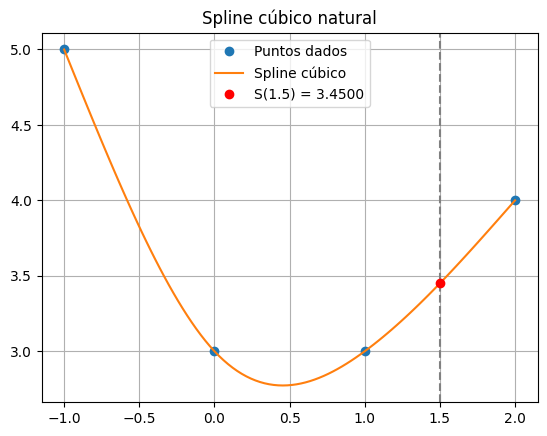

In [79]:
x = np.array([-1, 0, 1, 2])
y = np.array([5, 3, 3, 4])

cs = CubicSpline(x, y, bc_type='natural')

x_eval = 1.5
y_eval = cs(x_eval)

print(f"Spline evaluado en x = {x_eval}: {y_eval:.4f}")

x_plot = np.linspace(-1, 2, 100)
plt.plot(x, y, 'o', label='Puntos dados')
plt.plot(x_plot, cs(x_plot), label='Spline cúbico')
plt.axvline(x_eval, color='gray', linestyle='--')
plt.plot(x_eval, y_eval, 'ro', label=f'S({x_eval}) = {y_eval:.4f}')
plt.legend()
plt.grid()
plt.title('Spline cúbico natural')
plt.show()
